In [18]:
from math import log, sqrt, pi, exp
import math
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 

# Importing Data

In [10]:
btc_index_df = pd.read_excel("Perp_Data.xlsx", "Index Price") 
btc_perp_df = pd.read_excel("Perp_Data.xlsx", "Perp Future Price") 
btc_fr_df = pd.read_excel("Perp_Data.xlsx", "Funding Rate") 
btc_index_list = btc_index_df["price_close"].to_list().reverse()
btc_perp_list = btc_perp_df["price_close"].to_list().reverse()
btc_fr_list = btc_fr_df["Funding Rate"].to_list().reverse()

# Functions

In [14]:
def date_time_list(time):
    date_list = [time - timedelta(hours= (8 * i), minutes=0) for i in range(len(btc_index_list))]
    #date_list.reverse()
    date_list.reverse()
    return date_list
    
def non_cumulative_PNL(index, perp, fr):
    position_PNL = []
    fr_PNL = []
    both_PNL = []
    for i in range(len(index)):
        if index[i] < perp[i]:
            position_PNL.append(index[i] - perp[i]) 
            fr_PNL.append(fr[i] * index[i])
        else:
            position_PNL.append(perp[i] - index[i]) 
            fr_PNL.append(-fr[i] * index[i]) 
    
    both_PNL.append(position_PNL)
    both_PNL.append(fr_PNL)
    return both_PNL

def cumulative_PNL(position, fr, index):
    total_PNL = []
    total_PNL.append(position[0])
    for i in range(1, len(position)):
        if fr[i] * fr[i - 1] >= 0:
            total_PNL.append(position[i] + fr[i] * index[i] + total_PNL[i-1] - position[i-1]) #position PNL does not add up from last since it is constant
        else:
            total_PNL.append(position[i] + fr[i] * index[i] + total_PNL[i-1]) #position PNL adds up since position changes
    return total_PNL

# BTC Results

In [15]:
BTC_start_time = datetime(2022, 1, 6, hour = 11)
BTC_dates = date_time_list(BTC_start_time)
BTC_position = non_cumulative_PNL(btc_index_list, btc_perp_list, btc_fr_list)[0]
BTC_fr = non_cumulative_PNL(btc_index_list, btc_perp_list, btc_fr_list)[1]
BTC_total_PNL = cumulative_PNL(BTC_position, btc_fr_list, btc_index_list)

In [ ]:
#at any given time, future is most likely more expensive than the index because more people are long it
#I will be short on the future most times to get the funding rate
#Just sanity check that perp prices line up with index prices
btc_perp_list
btc_index_list
trues_falses = []
for i in range(len(btc_perp_list)):
    if btc_perp_list[i] > btc_index_list[i]:
        trues_falses.append(True)
    else:
        trues_falses.append(False)

In [16]:
BTC_df = pd.DataFrame(columns = ['Times'])
BTC_df["Times"] = BTC_dates
BTC_df["Index Price"] = btc_index_list
BTC_df["Perpetual Future Price"] = btc_perp_list
BTC_df["Funding Rate"] = btc_fr_list[:len(btc_perp_list)]
BTC_df["Positional PNL"] = BTC_position
BTC_df["Funding Rate PNL"] = BTC_fr
BTC_df["Accumulated PNL"] = BTC_total_PNL
BTC_df

,Times,Index Price,Perpetual Future Price,Funding Rate,Positional PNL,Funding Rate PNL,Accumulated PNL
0,2021-12-07 19:00:00,43067,43087,0.0001,-20,4.3067,-20.000000
1,2021-12-08 03:00:00,42939,42957,0.0001,-18,4.2939,-13.706100
2,2021-12-08 11:00:00,43231,43250,0.0001,-19,4.3231,-10.383000
3,2021-12-08 19:00:00,43444,43446,0.0001,-2,4.3444,10.961400
4,2021-12-09 03:00:00,46620,46633,0.0001,-13,4.6620,4.623400
...,...,...,...,...,...,...,...
85,2022-01-05 03:00:00,48489,48499,0.0001,-10,4.8489,317.592474
86,2022-01-05 11:00:00,50046,50053,0.0001,-7,5.0046,325.597074
87,2022-01-05 19:00:00,50517,50520,0.0001,-3,5.0517,334.648774
88,2022-01-06 03:00:00,50685,50707,0.0001,-22,5.0685,320.717274


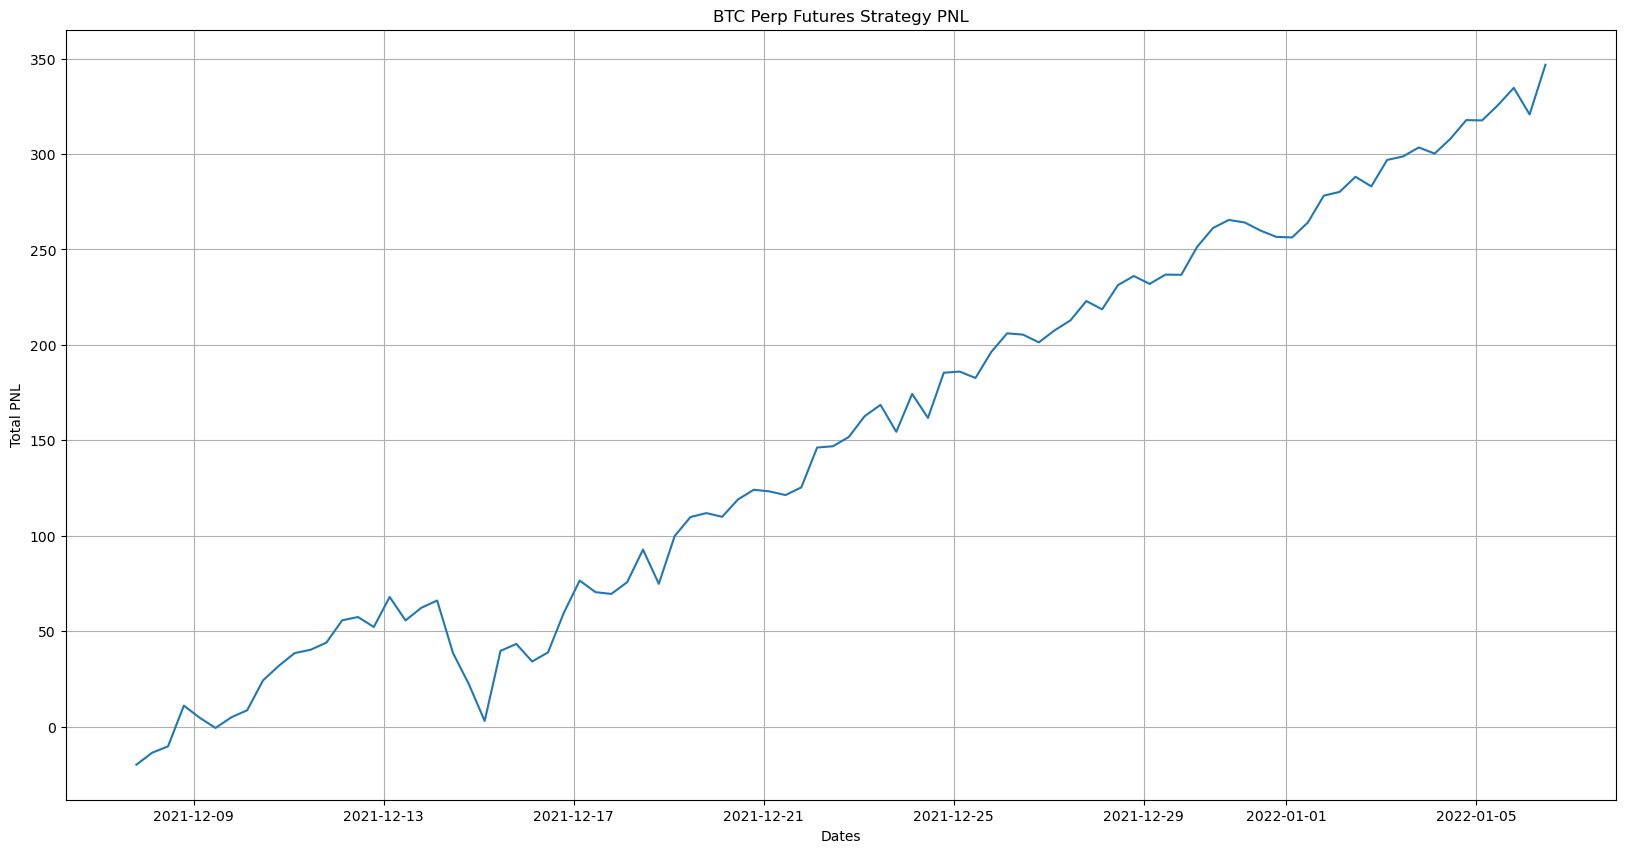

In [19]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('BTC Perp Futures Strategy PNL')
plt.xlabel('Dates')
plt.ylabel('Total PNL')
plt.plot(BTC_dates, BTC_total_PNL)
plt.show()